# Generate particles at defined locations

Sometime it is useful to generate images where the particle locations are not randomly generated but set by the user:

In [1]:
import synpivimage as spi 
spi.__version__

from pprint import pprint

In [2]:
import os
import numpy as np

dataset_dir = 'example_data_dir_definedloc'

In [3]:
cfg = spi.DEFAULT_CFG

cfg['bit_depth'] = 8
cfg['nx'] = 25
cfg['ny'] = 20
cfg['sensor_gain'] = 1.0
image_size = cfg['nx']*cfg['ny']
cfg['particle_number'] = 10
cfg['particle_size_illumination_dependency'] = True
cfg['particle_position_file'] = 'mypositions.txt'
cfg['square_image'] = False
cfg

{'ny': 20,
 'nx': 25,
 'square_image': False,
 'bit_depth': 8,
 'noise_baseline': 0.0,
 'dark_noise': 0.0,
 'sensitivity': 1,
 'qe': 1,
 'shot_noise': False,
 'particle_number': 10,
 'particle_size_mean': 2.5,
 'particle_size_std': 0.25,
 'laser_width': 3,
 'laser_shape_factor': 2,
 'sensor_gain': 1.0,
 'particle_position_file': 'mypositions.txt',
 'particle_size_illumination_dependency': True}

In [4]:
CFGs = spi.ConfigManager([cfg], )
CFGs

Configurations with 1 configurations

In [5]:
hdf_filename = CFGs.to_hdf(dataset_dir, nproc=1, overwrite=True)

Writing 1 dataset into 1 HDF5 file(s). This may take a while...


100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10cfg dict/s]

... done.


In [6]:
import h5rdmtoolbox as h5tbx
h5tbx.__version__

import matplotlib
import matplotlib.pyplot as plt

['image_bit_depth',
 'standard_deviation_of_mean_particle_diameter',
 'mean_particle_diameter',
 'image_particle_density',
 'x_pixel_coordinate',
 'laser_sheet_thickness',
 'saturated_pixel_number',
 'y_pixel_coordinate',
 'synthetic_particle_image']


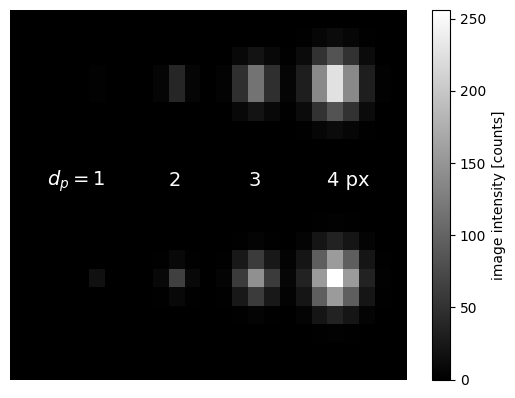

In [37]:
with h5tbx.H5File(hdf_filename[0]) as h5:
    pprint(h5.distinct('standard_name'))
    # h5.find_one({'standard_name': 'synthetic_particle_image'})[:].plot(cmap='gray',norm=matplotlib.colors.LogNorm(), vmin=1, vmax=2**8)
    plt.figure()
    h5.find_one({'standard_name': 'synthetic_particle_image'})[:].plot(cmap='gray', vmax=2**8)
    plt.text(1.8,10,'$d_p=1$', color='white', size=14)
    plt.text(9.5,10,'2', color='white', size=14)
    plt.text(14.5,10,'3', color='white', size=14)
    plt.text(19.5,10,'4 px', color='white', size=14)
    plt.axis('off')
    plt.title('')

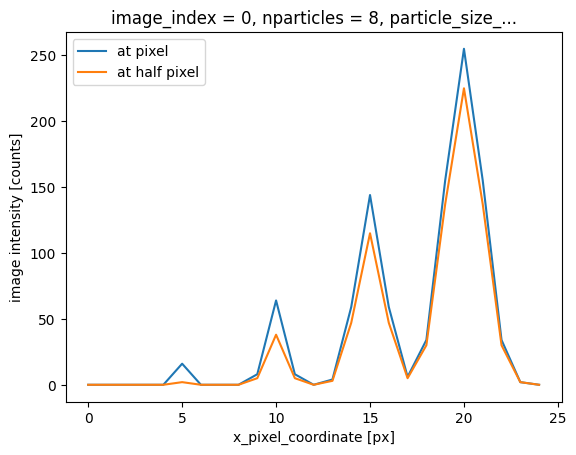

In [9]:
with h5tbx.H5File(hdf_filename[0]) as h5:
    h5.find_one({'standard_name': 'synthetic_particle_image'})[0,5,:].plot(label='at pixel')
    h5.find_one({'standard_name': 'synthetic_particle_image'})[0,15,:].plot(label='at half pixel')
    plt.legend()